In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
from sklearn.model_selection import train_test_split 
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [2]:
import sys

sys.path.insert(1, '../scripts')
from utilities import score

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
df = pd.read_csv('../data/ecom-user-churn-data.csv')

df = df.drop(['visitorid', 'int_cat15_n'], axis = 1)
X = df.drop(['target_class'], axis=1)
y = df['target_class']

In [22]:
BATCH_SIZE = 50

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, 
                                                    random_state=1010, 
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.20, 
                                                    random_state=1010, 
                                                    stratify=y_train)

# train data
X_train = torch.tensor(X_train.values)
y_train = torch.tensor(y_train.values)
dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

# validation data
X_val = torch.tensor(X_val.values)
y_val = torch.tensor(y_val.values)
dataset_val = TensorDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)


X_test = torch.tensor(X_test.values)
y_test = torch.tensor(y_test.values)
dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super().__init__()
        
        self.main = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.ReLU(), 
            nn.BatchNorm1d(hidden_size_1),
            nn.Dropout(0.3),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(), 
            nn.BatchNorm1d(hidden_size_2),
            nn.Linear(hidden_size_2, output_size),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [24]:
# model = SimpleNN(1, 20, 10, 2)
# summary(model, (1,))
# model.state_dict()

In [31]:
def trainer(model, criterion, optimizer, dataloader_train, dataloader_val, 
            epochs=5, patience=5, verbose=True):
    
    """
    Trains and validates a neural network model, tracks loss and metrics, and implements early stopping.

    Args:
        model (nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function to be used (e.g., nn.CrossEntropyLoss()).
        optimizer (torch.optim.Optimizer): The optimizer to be used (e.g., torch.optim.Adam()).
        dataloader_train (torch.utils.data.DataLoader): DataLoader for the training dataset.
        dataloader_val (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        epochs (int, optional): Number of epochs to train the model. Default is 5.
        patience (int, optional): Number of consecutive epochs with no improvement in validation loss 
                                  before early stopping. Default is 5.
        verbose (bool, optional): If True, prints the training and validation loss and accuracy for each epoch. Default is True.

    Returns:
        dict: A dictionary containing the following keys:
            'train_metrics' (dict): Dictionary of training metrics per epoch, including accuracy, precision, recall, and f1 score.
            'val_metrics' (dict): Dictionary of validation metrics per epoch, including accuracy, precision, recall, and f1 score.
    """
    
    per_epoch_train_loss = []
    per_epoch_val_loss = []
    
    # train metric
    train_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
        }
    
    # validation metric
    val_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
        }
    
    consec_increases = 0
    
    for epoch in range(epochs):
        batch_train_loss = 0
        
        batch_training = {
            'accuracy': 0,
            'precision': 0,
            'recall': 0,
            'f1': 0
        }
        
        # training
        for X_train, y_train in dataloader_train:
            X_train = X_train.float()
            y_train = y_train.long()
            
            optimizer.zero_grad()

            y_hat = model(X_train)
            y_hat_labels = torch.argmax(y_hat, dim=1)

            loss = criterion(y_hat, y_train)
            loss.backward()         
            optimizer.step()
            
            batch_train_loss += loss.item()
            train_scores = score(y_train, y_hat_labels)
            
            for i, key in enumerate(batch_training):
                batch_training[f'{key}'] += train_scores[i]
        
        # per batch loss
        avg_batch_train_loss = batch_train_loss / len(dataloader_train)
        per_epoch_train_loss.append(avg_batch_train_loss)
        
        # per batch metrics
        for key in train_metrics:
            batch_average = batch_training[f'{key}'] / len(dataloader_train)
            train_metrics[f'{key}'].append(batch_average)
            
        # validation
        model.eval()
        with torch.no_grad():
            batch_val_loss = 0
            
            batch_validation = {
                'accuracy': 0,
                'precision': 0,
                'recall': 0,
                'f1': 0}

            for X_val, y_val in dataloader_val:
                X_val = X_val.float()
                y_val = y_val.long()

                y_hat = model(X_val)
                y_hat_labels = torch.argmax(y_hat, dim=1)
                
                loss = criterion(y_hat, y_val)
                
                batch_val_loss += loss.item()
                val_scores = score(y_val, y_hat_labels)
                
                for i, key in enumerate(batch_validation):
                    batch_validation[f'{key}'] += val_scores[i]
                
        # per batch loss
        avg_batch_val_loss = batch_val_loss / len(dataloader_val)
        per_epoch_val_loss.append(avg_batch_val_loss)
                
        for key in val_metrics:
            batch_average = batch_validation[f'{key}'] / len(dataloader_val)
            val_metrics[f'{key}'].append(batch_average)
        
        model.train()
        
        if verbose: print(f"epoch: {epoch + 1}, train loss: {avg_batch_train_loss:.3f}, val loss: {avg_batch_val_loss:.3f}, train acc: {train_metrics['accuracy'][-1]:.3f}, val acc: {val_metrics['accuracy'][-1]:.3f}")
        
        # early stopping
        if epoch > 0 and per_epoch_val_loss[-1] > per_epoch_val_loss[-2]:
            consec_increases =+ 1
        
        else: 
            consec_increases = 0
        
        if consec_increases == patience:
            print(f'Stopped early at epoch {epoch + 1} because val loss increased for {consec_increases} consecutive epochs')
    
    # add loss to results
    train_metrics['loss'] = per_epoch_train_loss
    val_metrics['loss'] = per_epoch_val_loss
    
    results = {'train_metrics': train_metrics,
               'val_metrics': val_metrics}
    
    return results

In [32]:
# set hyperparameters
input_size = 46 # 1 x 46
hidden_size_1 = 20
hidden_size_2 = 10
num_classes = 2

num_epochs = 10
LEARNING_RATE = 0.1

model = SimpleNN(input_size, hidden_size_1, hidden_size_2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
training = trainer(model, criterion, optimizer, dataloader_train, 
                   dataloader_val, epochs=num_epochs, verbose=True)

epoch: 1, train loss: 0.410, val loss: 0.357, train acc: 0.811, val acc: 0.886
epoch: 2, train loss: 0.408, val loss: 0.355, train acc: 0.816, val acc: 0.886
epoch: 3, train loss: 0.411, val loss: 0.362, train acc: 0.814, val acc: 0.886
epoch: 4, train loss: 0.410, val loss: 0.423, train acc: 0.817, val acc: 0.858
epoch: 5, train loss: 0.408, val loss: 0.379, train acc: 0.818, val acc: 0.886
epoch: 6, train loss: 0.409, val loss: 0.365, train acc: 0.817, val acc: 0.886
epoch: 7, train loss: 0.410, val loss: 0.364, train acc: 0.816, val acc: 0.886
epoch: 8, train loss: 0.413, val loss: 0.429, train acc: 0.815, val acc: 0.886
epoch: 9, train loss: 0.410, val loss: 0.356, train acc: 0.818, val acc: 0.886
epoch: 10, train loss: 0.410, val loss: 0.378, train acc: 0.816, val acc: 0.886


In [33]:
train_df = pd.DataFrame(training['train_metrics']).add_prefix('train_')
val_df = pd.DataFrame(training['val_metrics']).add_prefix('val_')
results = pd.concat([train_df, val_df], axis=1)
results.head()

,train_accuracy,train_precision,train_recall,train_f1,train_loss,val_accuracy,val_precision,val_recall,val_f1,val_loss
0,0.810793,0.886599,0.901626,0.892830,0.409670,0.885549,0.885549,1.000000,0.938739,0.356505
1,0.816491,0.887216,0.908751,0.896623,0.408244,0.885549,0.885549,1.000000,0.938667,0.354612
2,0.814087,0.885669,0.907336,0.895245,0.411491,0.885538,0.885538,1.000000,0.938641,0.361778
3,0.816514,0.885721,0.910552,0.896866,0.409784,0.857938,0.896449,0.948751,0.921217,0.423239
4,0.817608,0.885925,0.911250,0.897474,0.407763,0.885527,0.885527,1.000000,0.938754,0.378773


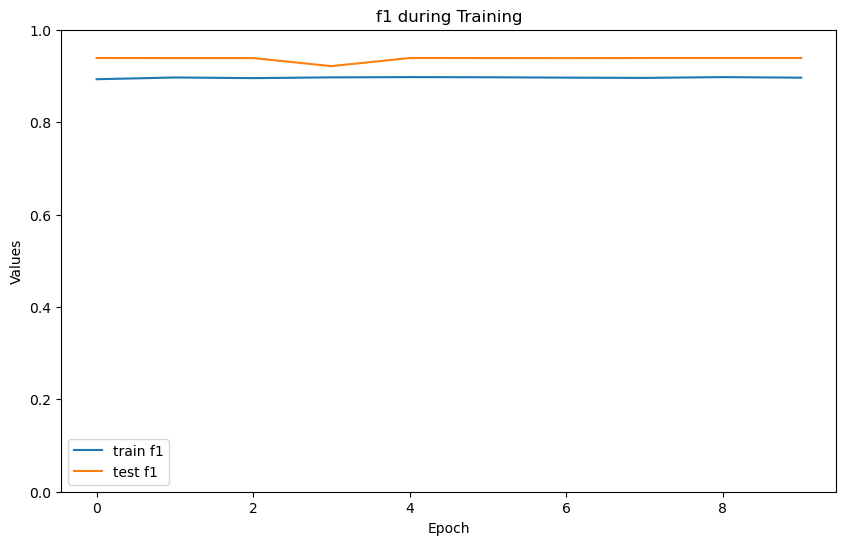

In [36]:
metric = 'f1'

plt.figure(figsize=(10, 6))
plt.plot(results.index, results[f'train_{metric}'], label=f'train {metric}')
plt.plot(results.index, results[f'val_{metric}'], label=f'test {metric}')

plt.xlabel('Epoch')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title(f'{metric} during Training')
plt.legend()
plt.show()
